# Import dataset from kaggle

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"atulsain","key":"5b7e6e3f79d29396e6e52e1a73526f28"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

 96% 297M/309M [00:02<00:00, 133MB/s]
100% 309M/309M [00:02<00:00, 121MB/s]


In [ ]:
!unzip "/content/human-emotions-datasethes.zip"

Streaming output truncated to the last 5000 lines.
  inflating: EmotionsDataset/data/nothing/720.jpg  
  inflating: EmotionsDataset/data/nothing/721.jpg  
  inflating: EmotionsDataset/data/nothing/722.jpg  
  inflating: EmotionsDataset/data/nothing/723.jpg  
  inflating: EmotionsDataset/data/nothing/724.jpg  
  inflating: EmotionsDataset/data/nothing/725.jpg  
  inflating: EmotionsDataset/data/nothing/726.jpg  
  inflating: EmotionsDataset/data/nothing/727.jpg  
  inflating: EmotionsDataset/data/nothing/728.jpg  
  inflating: EmotionsDataset/data/nothing/729.jpg  
  inflating: EmotionsDataset/data/nothing/73.jpg  
  inflating: EmotionsDataset/data/nothing/730.jpg  
  inflating: EmotionsDataset/data/nothing/731.jpg  
  inflating: EmotionsDataset/data/nothing/732.jpg  
  inflating: EmotionsDataset/data/nothing/733.jpg  
  inflating: EmotionsDataset/data/nothing/734.jpg  
  inflating: EmotionsDataset/data/nothing/735.jpg  
  inflating: EmotionsDataset/data/nothing/736.jpg  
  inflating: E

# Initial Setup

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dense, Dropout, Resizing, Rescaling
from tensorflow.keras.regularizers import L2
import matplotlib.pyplot as plt
import numpy as np
import cv2## image processing

In [ ]:
CONFIGURATION = {
    'BATCH_SIZE': 32,
    "IM_SIZE": 256
}

In [ ]:
def load_dataset():
  train_directory = "/content/EmotionsDataset_Splitted/data/train"
  test_directory = "/content/EmotionsDataset_Splitted/data/test"

  train_dataset, val_dataset = tf.keras.utils.image_dataset_from_directory(
                                                            train_directory,
                                                            labels='inferred',
                                                            label_mode='int',
                                                            class_names=None,
                                                            color_mode='rgb',
                                                            batch_size=CONFIGURATION['BATCH_SIZE'],
                                                            image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
                                                            shuffle=True,
                                                            seed=99,
                                                            validation_split=0.2,
                                                            subset='both',
                                                            interpolation='bilinear',
                                                            follow_links=False,
                                                            crop_to_aspect_ratio=False
                                                            )

  test_dataset = tf.keras.utils.image_dataset_from_directory(
                                                            test_directory,
                                                            labels='inferred',
                                                            label_mode='int',
                                                            class_names=None,
                                                            color_mode='rgb',
                                                            batch_size=CONFIGURATION['BATCH_SIZE'],
                                                            image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
                                                            shuffle=True,
                                                            seed=None,
                                                            validation_split=None,
                                                            subset=None,
                                                            interpolation='bilinear',
                                                            follow_links=False,
                                                            crop_to_aspect_ratio=False
                                                            )
  print(f"Train Batch Count: {len(train_dataset)}")
  print(f"Val Batch Count: {len(val_dataset)}")
  print(f"Test Batch Count: {len(test_dataset)}")
  return train_dataset, val_dataset, test_dataset

# Data Visualization

In [ ]:
CLASS_NAMES = ['angry', 'happy', 'nothing', 'sad']

def explore_dataset(dataset, model = None):

  plt.figure(figsize=(12, 12))

  if model:
    for images, labels in dataset.shuffle(1024).take(1):
      for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i]/255)
        plt.title(f"True Label: {CLASS_NAMES[labels[i].numpy()]}\nPred Label: {CLASS_NAMES[tf.argmax(model(i), axis=0)]}")
        plt.axis('off')
  else:
    for images, labels in dataset.shuffle(1024).take(1):
      for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i]/255)
        plt.title(CLASS_NAMES[labels[i].numpy()])
        plt.axis('off')

# Data Preparation

In [ ]:
image_augmentation_layer = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=(0, 2)),
    tf.keras.layers.RandomFlip(mode="horizontal_and_vertical"),
    tf.keras.layers.RandomContrast(factor=0.1)
])

def image_augmentation(image, label):
  image = image_augmentation_layer(image)
  return image, label

In [ ]:
def prepare_dataset(train_dataset, val_dataset, test_dataset):
  train_dataset = (train_dataset
                   .map(image_augmentation, num_parallel_calls = tf.data.AUTOTUNE)
                  .prefetch(tf.data.AUTOTUNE)
                  )

  val_dataset = (val_dataset
                  .prefetch(tf.data.AUTOTUNE)
                  )

  test_dataset = (test_dataset
                  .prefetch(tf.data.AUTOTUNE)
                  )
  return train_dataset, val_dataset, test_dataset

## CutMix Data Augmentation

In [ ]:
# did not implement

# Modeling

In [ ]:
def load_modeling_dataset():
  train_dataset, val_dataset, test_dataset = load_dataset()
  train_dataset, val_dataset, test_dataset = prepare_dataset(train_dataset, val_dataset, test_dataset)
  return train_dataset, val_dataset, test_dataset

In [ ]:
train_dataset, val_dataset, test_dataset = load_modeling_dataset()

Found 3152 files belonging to 4 classes.
Using 2522 files for training.
Using 630 files for validation.
Found 788 files belonging to 4 classes.
Train Batch Count: 79
Val Batch Count: 20
Test Batch Count: 25


In [ ]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-2,
    "N_EPOCHS": 50,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.01,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 3,
    "N_DENSE_1": 64,
    "N_DENSE_2": 16,
    "NUM_CLASSES": 4,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", 'nothing', "sad"],
}

In [ ]:
class CreateModel():
  def __init__(self):
    self.model = None

  def create_lenet_model(self):
    lenet_model = tf.keras.Sequential(
        [
        InputLayer(input_shape = (None, None, 3), ),

        Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
        Rescaling(1./255),

        Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
              activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
        BatchNormalization(),
        MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
        Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

        Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
              activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
        BatchNormalization(),
        MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

        Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
              activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
        BatchNormalization(),
        MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

        Flatten(),

        Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
        BatchNormalization(),
        Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

        Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
        BatchNormalization(),

        Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

    ])

    self.model = lenet_model

    return self.model

    def summary(self):
      return self.model.summary()

    def plot_model(self):
      return tf.keras.utils.plot_model(self.model, show_shapes=True, show_dtype=True, show_layer_activations=True, show_trainable=True)

# Training

## Model Compilation

In [ ]:
modeling_class = CreateModel()
lenet_model = modeling_class.create_lenet_model()

In [ ]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

In [ ]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'), tf.keras.metrics.SparseTopKCategoricalAccuracy(k=2, name='top_k_accuracy')]

### CallBacks

In [ ]:
def scheduler(epoch, lr):
  if epoch % 10 ==0 and epoch !=0:
    return lr * tf.math.exp(-0.1)
  else:
    return lr

In [ ]:
lr_schedular = tf.keras.callbacks.LearningRateScheduler(
                    schedule=scheduler, verbose=1
                )

### Compile

In [ ]:
from keras.callbacks import Callback
lenet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
                    loss = loss_function,
                    metrics = metrics)

## Model Training

In [ ]:
history = lenet_model.fit(train_dataset,
                          validation_data=val_dataset,
                          epochs=CONFIGURATION['N_EPOCHS'],
                          verbose=1, callbacks=[lr_schedular])


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/50
79/79 [==============================] - 196s 2s/step - loss: 6.0437 - accuracy: 0.5626 - top_k_accuracy: 0.8128 - val_loss: 2.7721 - val_accuracy: 0.2635 - val_top_k_accuracy: 0.5302 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/50
79/79 [==============================] - 197s 2s/step - loss: 1.5013 - accuracy: 0.5817 - top_k_accuracy: 0.8121 - val_loss: 2.6115 - val_accuracy: 0.2635 - val_top_k_accuracy: 0.4651 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/50
79/79 [==============================] - 203s 3s/step - loss: 1.4118 - accuracy: 0.5781 - top_k_accuracy: 0.8232 - val_loss: 1.9098 - val_accuracy: 0.3397 - val_top_k_accuracy: 0.6095 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 4/50
79/79 [==============================] - 202s 3s/

In [ ]:
def plot_history(history):
  if history.history['loss']:
    epochs = np.arange(len(history.history['loss'])) + 1
    plt.plot(epochs, history.history['loss'])
    plt.plot(epochs, history.history['val_loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train Loss', 'Val Loss'])
    plt.title('Loss')
    plt.show()

  if history.history['accuracy']:
    plt.plot(epochs, history.history['accuracy'])
    plt.plot(epochs, history.history['val_accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train Accuracy', 'Val Accuracy'])
    plt.title('Categorical Accuracy')
    plt.show()

  if history.history['top_k_accuracy']:
    plt.plot(epochs, history.history['top_k_accuracy'])
    plt.plot(epochs, history.history['val_top_k_accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Top K Accuracy')
    plt.legend(['Train Accuracy', 'Val Accuracy'])
    plt.title('K_top Accuracy')
    plt.show()

  if history.history['lr']:
    plt.scatter(history.history['lr'], history.history['accuracy'])
    plt.scatter(history.history['lr'], history.history['val_accuracy'])
    plt.xlabel('lr')
    plt.ylabel('accuracy')
    plt.legend(['Train Accuracy', 'Val Accuracy'])
    plt.title('Lr vs Accuracy')
    plt.show()

In [ ]:
plot_history(history)

# TF Records

In [ ]:
def create_example(image, label):

  bytes_feature = tf.train.Feature(
      bytes_list=BytesList(value=[image]))

  int_feature = tf.train.Feature(
      int64_list=tf.train.Int64List(value=[label]))

  example = Example(
      features=Features(feature={
          'images': bytes_feature,
          'labels': int_feature,
      }))

  return example.SerializeToString()

In [ ]:
NUM_SHARDS = 10
PATH = 'tfrecords/shard_{:02d}.tfrecord'

In [ ]:
def encode_image(image, label):
  image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
  image = tf.io.encode_jpeg(image)
  return image,tf.argmax(label)

In [ ]:
encoded_dataset = (
  train_dataset
  .map(encode_image)
)

In [ ]:
for shard_number in range(NUM_SHARDS):

  sharded_dataset = (
      encoded_dataset
      .shard(NUM_SHARDS, shard_number)
      .as_numpy_iterator()
  )

  with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
    for encoded_image, encoded_label in sharded_dataset:

      example = create_example(encoded_image, encoded_label)
      file_writer.write(example)

In [ ]:
recons_dataset = tf.data.TFRecordDataset(
    filenames =[PATH.format(p) for p in range(NUM_SHARDS-2)] )
# val_recons_dataset = tf.data.TFRecordDataset(
#     filenames =[PATH.format(p) for p in range(NUM_SHARDS-2,NUM_SHARDS)] )

In [ ]:
def parse_tfrecords(example):

    feature_description = {
          "images": tf.io.FixedLenFeature([], tf.string),
          "labels": tf.io.FixedLenFeature([], tf.int64),
      }

    example = tf.io.parse_single_example(example, feature_description)
    example["images"] = tf.image.convert_image_dtype(
        tf.io.decode_jpeg(
        example["images"], channels = 3), dtype = tf.float32)

    return example["images"], example["labels"]

In [ ]:
parsed_dataset = (
    recons_dataset
    .map(parse_tfrecords)
    .batch(CONFIGURATION["BATCH_SIZE"])
    .prefetch(tf.data.AUTOTUNE)
)


In [ ]:
parsed_dataset

# ResNet model

## subclassing

In [ ]:
class CustomConvLayer(tf.keras.layers.Layer):
  def __init__(self, filters, strides = 1, **kwargs):
    super(CustomConvLayer, self).__init__(**kwargs)
    self.strides = strides
    self.filters = filters

    self.conv_1 = tf.keras.layers.Conv2D(kernel_size=(3,3), strides=self.strides, padding='same', filters=self.filters, activation=None)
    self.max_pool_1 = tf.keras.layers.MaxPooling2D(strides=1, padding='same')
    self.normalization_1 = tf.keras.layers.LayerNormalization()
    self.activation = tf.keras.layers.ReLU()

  def call(self, input):
    # print(input.shape)
    x = self.conv_1(input)
    x = self.max_pool_1(x)
    x = self.normalization_1(x)
    x = self.activation(x)
    return x

In [ ]:
class InitializerCNN(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(InitializerCNN, self).__init__(**kwargs)
    self.input_layer = tf.keras.layers.InputLayer(input_shape=(None, 256, 256, 3))
    self.cnn_prime = tf.keras.layers.Conv2D(filters=64, kernel_size=(7,7), strides=(1,1), padding='valid', activation = None)
    self.maxpool_prime = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides = (1, 1), padding='valid')
    self.layer_normalization_prime = tf.keras.layers.LayerNormalization()

  def call(self, input):
    x = self.input_layer(input)
    x = self.cnn_prime(x)
    x = self.maxpool_prime(x)
    x = self.layer_normalization_prime(x)
    return x

In [ ]:
class IdentityBlock(tf.keras.layers.Layer):
  def __init__(self, filters, strides=(1,1), **kwargs):
    super(IdentityBlock, self).__init__(**kwargs)
    self.filters = filters
    self.strides = strides
    self.conv1 = CustomConvLayer(self.filters, self.strides)
    self.conv2 = CustomConvLayer(self.filters, 1)
    self.add_conv = tf.keras.layers.Conv2D(filters=self.filters, kernel_size = (1, 1), padding='same')
    self.add = tf.keras.layers.Add()
    self.normalize = tf.keras.layers.LayerNormalization()
    self.activation_1 = tf.keras.layers.ReLU()
    self.activation_2 = tf.keras.layers.ReLU()

  def call(self, input):
    x = self.conv1(input)
    x = self.activation_1(x)
    x = self.conv2(x)
    if self.strides !=2:
      x = self.add([self.add_conv(input), x])
      # print("Skip Connection Activated")
    # else:
    #   x = self.add([input, x])
      # print("Skip Connection Skipped..................")
    x = self.normalize(x)
    x = self.activation_2(x)

    return x

In [ ]:
class ResnetModel(tf.keras.models.Model):
  def __init__(self, num_classes, **kwargs):
    super(ResnetModel, self).__init__(**kwargs)

    self.num_classes = num_classes
    self.initializer = InitializerCNN()
    self.resnet_64 = [IdentityBlock(filters=64) if i<2 else IdentityBlock(filters=64, strides=2) for i in range(3)]
    self.resnet_128 = [IdentityBlock(filters=128) if i<2 else IdentityBlock(filters=128, strides=2) for i in range(3)]
    self.resnet_256 = [IdentityBlock(filters=256) if i<2 else IdentityBlock(filters=256, strides=2) for i in range(3)]
    self.resnet_512 = [IdentityBlock(filters=512) if i<2 else IdentityBlock(filters=512, strides=2) for i in range(3)]
    self.global_avg_pool = tf.keras.layers.GlobalAveragePooling2D()
    self.flatten = tf.keras.layers.Flatten()
    self.dense_1 = tf.keras.layers.Dense(1000)
    self.dense_2 = tf.keras.layers.Dense(10)
    self.output_array = tf.keras.layers.Dense(self.num_classes, activation='softmax')

  def call(self, input):
    x = self.initializer(input)

    for i in range(3):
      x = self.resnet_64[i](x)
    for i in range(3):
      x = self.resnet_128[i](x)
    for i in range(3):
      x = self.resnet_256[i](x)
    for i in range(3):
      x = self.resnet_512[i](x)

    x = self.global_avg_pool(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.dense_2(x)
    x = self.output_array(x)
    return x

In [ ]:
model = ResnetModel(4)

In [ ]:
# model.build(input_shape=(None, 256, 256, 3))

In [ ]:
# model.summary()

In [ ]:
# tf.keras.utils.plot_model(model, expand_nested=True)

In [ ]:
# Loss Function
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

In [ ]:
# metrics
metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name='Accuracy'), tf.keras.metrics.SparseTopKCategoricalAccuracy(k=2, name='top_k_accuracy')]

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss = loss_function,
    metrics = metrics
)

In [ ]:
train_dataset, val_dataset, test_dataset = load_modeling_dataset()

Found 3152 files belonging to 4 classes.
Using 2522 files for training.
Using 630 files for validation.
Found 788 files belonging to 4 classes.
Train Batch Count: 79
Val Batch Count: 20
Test Batch Count: 25


In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

Epoch 1/20


# Transfer Learning with EfficientNetB4

In [ ]:
train_dataset, val_dataset, test_dataset = load_modeling_dataset()

Found 3152 files belonging to 4 classes.
Using 2522 files for training.
Using 630 files for validation.
Found 788 files belonging to 4 classes.
Train Batch Count: 79
Val Batch Count: 20
Test Batch Count: 25


## Sequential

In [ ]:
EfficientNetB4 = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top=False,
    weights='imagenet',
    input_shape = (256, 256, 3),
)

71686520/71686520 [==============================] - 0s 0us/step


In [ ]:
EfficientNetB4.trainable = False

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(256, 256, 3)),
    EfficientNetB4,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1000, 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(4, 'softmax'),

])

In [ ]:
model.compile()

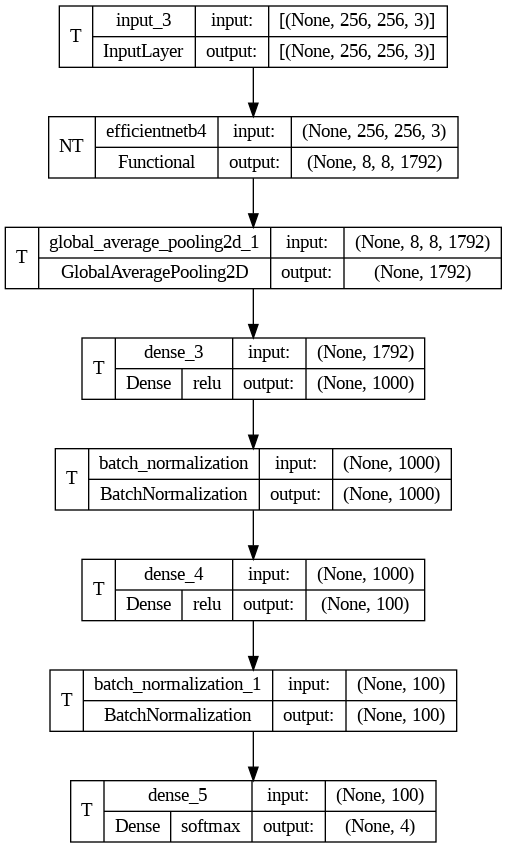

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_trainable=True, show_layer_activations=True)

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'best_weights',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

In [ ]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

In [ ]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name='accurracy'), tf.keras.metrics.SparseTopKCategoricalAccuracy(name='top_k_accuracy')]

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss = loss_function,
    metrics = metrics
)

In [ ]:
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[checkpoint_callback], verbose=1)

Epoch 1/10
79/79 [==============================] - ETA: 0s - loss: 1.4856 - accurracy: 0.3898 - top_k_accuracy: 1.0000

79/79 [==============================] - 87s 691ms/step - loss: 1.4856 - accurracy: 0.3898 - top_k_accuracy: 1.0000 - val_loss: 1.2286 - val_accurracy: 0.4460 - val_top_k_accuracy: 1.0000
Epoch 2/10
79/79 [==============================] - ETA: 0s - loss: 1.0741 - accurracy: 0.5591 - top_k_accuracy: 1.0000

79/79 [==============================] - 39s 479ms/step - loss: 1.0741 - accurracy: 0.5591 - top_k_accuracy: 1.0000 - val_loss: 1.1018 - val_accurracy: 0.5063 - val_top_k_accuracy: 1.0000
Epoch 3/10
79/79 [==============================] - ETA: 0s - loss: 0.9673 - accurracy: 0.6094 - top_k_accuracy: 1.0000

79/79 [==============================] - 40s 493ms/step - loss: 0.9673 - accurracy: 0.6094 - top_k_accuracy: 1.0000 - val_loss: 0.9829 - val_accurracy: 0.5905 - val_top_k_accuracy: 1.0000
Epoch 4/10
79/79 [==============================] - ETA: 0s - loss: 0.8823 - accurracy: 0.6388 - top_k_accuracy: 1.0000

79/79 [==============================] - 39s 486ms/step - loss: 0.8823 - accurracy: 0.6388 - top_k_accuracy: 1.0000 - val_loss: 0.8887 - val_accurracy: 0.6302 - val_top_k_accuracy: 1.0000
Epoch 5/10
79/79 [==============================] - ETA: 0s - loss: 0.8190 - accurracy: 0.6542 - top_k_accuracy: 1.0000

79/79 [==============================] - 41s 517ms/step - loss: 0.8190 - accurracy: 0.6542 - top_k_accuracy: 1.0000 - val_loss: 0.8295 - val_accurracy: 0.6429 - val_top_k_accuracy: 1.0000
Epoch 6/10
79/79 [==============================] - ETA: 0s - loss: 0.7888 - accurracy: 0.6681 - top_k_accuracy: 1.0000

79/79 [==============================] - 34s 411ms/step - loss: 0.7888 - accurracy: 0.6681 - top_k_accuracy: 1.0000 - val_loss: 0.8054 - val_accurracy: 0.6508 - val_top_k_accuracy: 1.0000
Epoch 7/10
79/79 [==============================] - ETA: 0s - loss: 0.7614 - accurracy: 0.6800 - top_k_accuracy: 1.0000

79/79 [==============================] - 42s 521ms/step - loss: 0.7614 - accurracy: 0.6800 - top_k_accuracy: 1.0000 - val_loss: 0.7752 - val_accurracy: 0.6667 - val_top_k_accuracy: 1.0000
Epoch 8/10
79/79 [==============================] - ETA: 0s - loss: 0.7391 - accurracy: 0.6907 - top_k_accuracy: 1.0000

79/79 [==============================] - 32s 394ms/step - loss: 0.7391 - accurracy: 0.6907 - top_k_accuracy: 1.0000 - val_loss: 0.7736 - val_accurracy: 0.6762 - val_top_k_accuracy: 1.0000
Epoch 9/10
79/79 [==============================] - ETA: 0s - loss: 0.7316 - accurracy: 0.6899 - top_k_accuracy: 1.0000

79/79 [==============================] - 42s 519ms/step - loss: 0.7316 - accurracy: 0.6899 - top_k_accuracy: 1.0000 - val_loss: 0.7651 - val_accurracy: 0.6810 - val_top_k_accuracy: 1.0000
Epoch 10/10
79/79 [==============================] - ETA: 0s - loss: 0.7108 - accurracy: 0.6987 - top_k_accuracy: 1.0000

79/79 [==============================] - 29s 366ms/step - loss: 0.7108 - accurracy: 0.6987 - top_k_accuracy: 1.0000 - val_loss: 0.7517 - val_accurracy: 0.6873 - val_top_k_accuracy: 1.0000


## Subclassing

In [ ]:
# we had set EfficientNetB4.trainable = False before

class EfficientNetModel(tf.keras.models.Model):
  def __init__(self):
    super(EfficientNetModel, self).__init__()
    self.input_layer = tf.keras.layers.InputLayer(input_shape=(None, 256, 256, 3))
    self.efficient = tf.keras.applications.efficientnet.EfficientNetB4(
                                                                          include_top=False,
                                                                          weights='imagenet',
                                                                          input_shape = (256, 256, 3),
                                                                      )
    self.global_average = tf.keras.layers.GlobalAveragePooling2D()
    self.dense = tf.keras.layers.Dense(1000, activation='relu')
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()
    self.dense_1 = tf.keras.layers.Dense(100, activation='relu')
    self.batch_norm_2 = tf.keras.layers.BatchNormalization()
    self.dense_2 = tf.keras.layers.Dense(4, activation='softmax')

  def call(self, input):
    self.efficient.trainable = False
    x = self.input_layer(input)
    x = self.efficient(x)
    x = self.global_average(x)
    x = self.dense(x)
    x = self.batch_norm_1(x)
    x = self.dense_1(x)
    x = self.batch_norm_2(x)
    x = self.dense_2(x)
    return x

In [ ]:
subclassed_efficient_net = EfficientNetModel()

In [ ]:
subclassed_efficient_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss = loss_function,
    metrics = metrics
)

In [ ]:
history_1 = subclassed_efficient_net.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[checkpoint_callback], verbose=1)

Epoch 1/10
79/79 [==============================] - ETA: 0s - loss: 1.4987 - accurracy: 0.4603 - top_k_accuracy: 1.0000

79/79 [==============================] - 49s 424ms/step - loss: 1.4987 - accurracy: 0.4603 - top_k_accuracy: 1.0000 - val_loss: 1.2224 - val_accurracy: 0.5111 - val_top_k_accuracy: 1.0000
Epoch 2/10
79/79 [==============================] - ETA: 0s - loss: 1.0582 - accurracy: 0.5515 - top_k_accuracy: 1.0000

79/79 [==============================] - 29s 359ms/step - loss: 1.0582 - accurracy: 0.5515 - top_k_accuracy: 1.0000 - val_loss: 1.0630 - val_accurracy: 0.5635 - val_top_k_accuracy: 1.0000
Epoch 3/10
79/79 [==============================] - ETA: 0s - loss: 0.9316 - accurracy: 0.5979 - top_k_accuracy: 1.0000

79/79 [==============================] - 29s 354ms/step - loss: 0.9316 - accurracy: 0.5979 - top_k_accuracy: 1.0000 - val_loss: 0.9403 - val_accurracy: 0.5921 - val_top_k_accuracy: 1.0000
Epoch 4/10
79/79 [==============================] - ETA: 0s - loss: 0.8745 - accurracy: 0.6289 - top_k_accuracy: 1.0000

79/79 [==============================] - 31s 380ms/step - loss: 0.8745 - accurracy: 0.6289 - top_k_accuracy: 1.0000 - val_loss: 0.8382 - val_accurracy: 0.6254 - val_top_k_accuracy: 1.0000
Epoch 5/10
79/79 [==============================] - ETA: 0s - loss: 0.8286 - accurracy: 0.6435 - top_k_accuracy: 1.0000

79/79 [==============================] - 30s 367ms/step - loss: 0.8286 - accurracy: 0.6435 - top_k_accuracy: 1.0000 - val_loss: 0.7925 - val_accurracy: 0.6429 - val_top_k_accuracy: 1.0000
Epoch 6/10
79/79 [==============================] - ETA: 0s - loss: 0.7981 - accurracy: 0.6538 - top_k_accuracy: 1.0000

79/79 [==============================] - 29s 356ms/step - loss: 0.7981 - accurracy: 0.6538 - top_k_accuracy: 1.0000 - val_loss: 0.7634 - val_accurracy: 0.6651 - val_top_k_accuracy: 1.0000
Epoch 7/10
79/79 [==============================] - ETA: 0s - loss: 0.7490 - accurracy: 0.6685 - top_k_accuracy: 1.0000

79/79 [==============================] - 29s 363ms/step - loss: 0.7490 - accurracy: 0.6685 - top_k_accuracy: 1.0000 - val_loss: 0.7416 - val_accurracy: 0.6762 - val_top_k_accuracy: 1.0000
Epoch 8/10
79/79 [==============================] - ETA: 0s - loss: 0.7328 - accurracy: 0.6872 - top_k_accuracy: 1.0000

79/79 [==============================] - 29s 357ms/step - loss: 0.7328 - accurracy: 0.6872 - top_k_accuracy: 1.0000 - val_loss: 0.7220 - val_accurracy: 0.7016 - val_top_k_accuracy: 1.0000
Epoch 9/10
79/79 [==============================] - ETA: 0s - loss: 0.7125 - accurracy: 0.6959 - top_k_accuracy: 1.0000

79/79 [==============================] - 29s 356ms/step - loss: 0.7125 - accurracy: 0.6959 - top_k_accuracy: 1.0000 - val_loss: 0.7167 - val_accurracy: 0.7063 - val_top_k_accuracy: 1.0000
Epoch 10/10
79/79 [==============================] - ETA: 0s - loss: 0.6888 - accurracy: 0.7105 - top_k_accuracy: 1.0000

79/79 [==============================] - 28s 349ms/step - loss: 0.6888 - accurracy: 0.7105 - top_k_accuracy: 1.0000 - val_loss: 0.7042 - val_accurracy: 0.7063 - val_top_k_accuracy: 1.0000


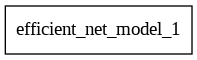

In [ ]:
tf.keras.utils.plot_model(subclassed_efficient_net, show_shapes=True, show_trainable=True, show_layer_activations=True, expand_nested=True)

In [ ]:
subclassed_efficient_net.evaluate(test_dataset)

25/25 [==============================] - 6s 230ms/step - loss: 0.6684 - accurracy: 0.7119 - top_k_accuracy: 1.0000


[0.6684331893920898, 0.7119289636611938, 1.0]

## Functional

In [ ]:
# we had set EfficientNetB4.trainable = False before

input = tf.keras.layers.Input(shape=(256, 256, 3))
x = EfficientNetB4(input)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1000, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(100, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
output = tf.keras.layers.Dense(100, activation='softmax')(x)

model = tf.keras.models.Model(input, output)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, 8, 8, 1792)       17673823  
                                                                 
 global_average_pooling2d_4   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 1000)              1793000   
                                                                 
 batch_normalization_6 (Batc  (None, 1000)             4000      
 hNormalization)                                                 
                                                                 
 dense_13 (Dense)            (None, 100)               100100

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.614673 to fit



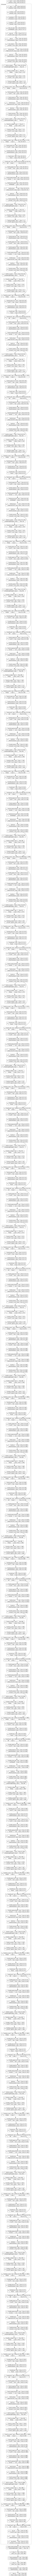

In [ ]:
tf.keras.utils.plot_model(model,
                          show_shapes=True,
                          show_trainable=True,
                          show_layer_activations=True,
                          expand_nested=True
                          )

# Fine Tuning

In [ ]:
EfficientNetB4.trainable = True

In [ ]:
# we had set EfficientNetB4.trainable = False before

input = tf.keras.layers.Input(shape=(256, 256, 3))
x = EfficientNetB4(input)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1000, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(100, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
output = tf.keras.layers.Dense(100, activation='softmax')(x)

finetuned_model = tf.keras.models.Model(input, output)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.614673 to fit



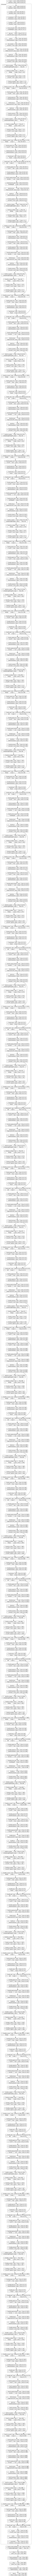

In [ ]:
tf.keras.utils.plot_model(finetuned_model,
                          show_shapes=True,
                          show_trainable=True,
                          show_layer_activations=True,
                          expand_nested=True
                          )

In [ ]:
finetuned_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss = loss_function,
    metrics = metrics
)

In [ ]:
finetuned_model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[checkpoint_callback], verbose=1
                    )

Epoch 1/10
10/79 [==>...........................] - ETA: 37:51 - loss: 5.0242 - accurracy: 0.0125 - top_k_accuracy: 0.0437

# Grad Cam

In [ ]:
train_dataset, val_dataset, test_dataset = load_modeling_dataset()

Found 3152 files belonging to 4 classes.
Using 2522 files for training.
Using 630 files for validation.
Found 788 files belonging to 4 classes.
Train Batch Count: 79
Val Batch Count: 20
Test Batch Count: 25


In [ ]:
img_path = "/content/EmotionsDataset/data/happy/108.jpg"

In [ ]:
efficient_grad_cam = tf.keras.applications.efficientnet.EfficientNetB5(
    include_top=False,
    weights = 'imagenet',
    input_shape=(256, 256, 3)
)

efficient_grad_cam.trainable = False

115263384/115263384 [==============================] - 1s 0us/step


In [ ]:
input = tf.keras.layers.Input(shape=(256, 256, 3))
x = efficient_grad_cam.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(100, activation='relu')(x)
x = tf.keras.layers.Dense(10, activation='relu')(x)
output = tf.keras.layers.Dense(4, activation='softmax')(x)

pretrained_model = tf.keras.models.Model(efficient_grad_cam.inputs, output)
pretrained_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['normalization[0][0]']      

In [ ]:
image_path = "/content/EmotionsDataset_Splitted/data/test/happy/1012.jpg"

In [ ]:
test_image = cv2.imread(image_path)
test_image = cv2.resize(test_image, (256, 256))
im = tf.constant(test_image, dtype=tf.float32)
image_array = tf.expand_dims(im, axis=0)
print(image_array.shape)

(1, 256, 256, 3)


In [ ]:
preds = pretrained_model.predict(image_array)

1/1 [==============================] - 5s 5s/step


In [ ]:
np.argmax(preds[0])

1

In [ ]:
last_conv_layer_name = 'top_activation'
last_conv_layer = pretrained_model.get_layer(last_conv_layer_name)
last_conv_layer_model = tf.keras.models.Model(pretrained_model.inputs, last_conv_layer.output)

In [ ]:
last_conv_layer_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['normalization[0][0]']    

In [ ]:
classifier_layer_name = [
    'global_average_pooling2d_1',
    'dense_3',
    'dense_4',
    'dense_5'
]

In [ ]:
classifier_input = tf.keras.layers.Input(shape=(8, 8, 2048))
x = classifier_input
for layer_name in classifier_layer_name:
  x = pretrained_model.get_layer(layer_name)(x)
classifier_model = tf.keras.models.Model(classifier_input, x)

In [ ]:
with tf.GradientTape() as tape:
  last_conv_layer_output = last_conv_layer_model(image_array)
  preds = classifier_model(last_conv_layer_output)
  top_pred_index = tf.argmax(preds[0])
  top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [ ]:
pooled_grads = tf.reduce_mean(grads, axis= (0, 1, 2)).numpy()

In [ ]:
print(pooled_grads.shape)

(2048,)


In [ ]:
 last_conv_layer_output = last_conv_layer_output.numpy()[0]
 for i in range(2048):
  last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [ ]:
print(last_conv_layer_output.shape)

(8, 8, 2048)


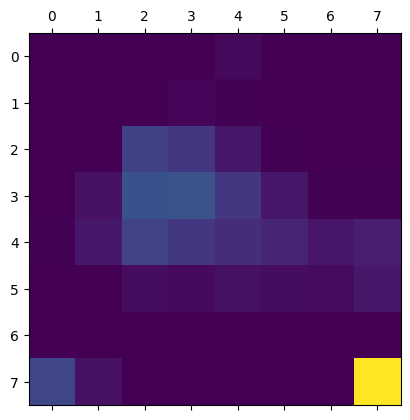

In [ ]:
heatmap = np.sum(last_conv_layer_output, axis=-1)
heatmap = tf.nn.relu(heatmap)
plt.matshow(heatmap)

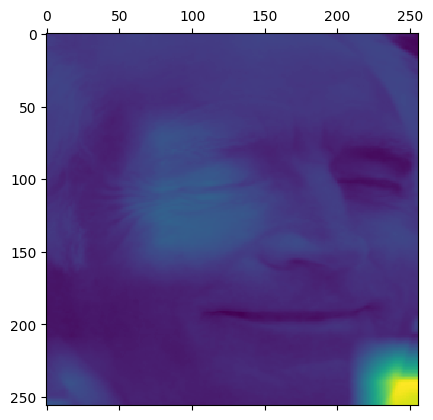

In [ ]:
resized_heatmap = cv2.resize(np.array(heatmap), (256, 256))
plt.matshow(resized_heatmap*255 + image_array[0, :, :, 0]/255)

# Layer Visualization

In [ ]:
vgg_pretrained = tf.keras.applications.vgg16.VGG16(
    include_top = False,
    weights = 'imagenet',
    input_shape=(256, 256, 3)
)

In [ ]:
vgg_pretrained.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
train_dataset, val_dataset, test_dataset = load_modeling_dataset()

Found 3152 files belonging to 4 classes.
Using 2522 files for training.
Using 630 files for validation.
Found 788 files belonging to 4 classes.
Train Batch Count: 79
Val Batch Count: 20
Test Batch Count: 25


In [ ]:
def is_conv(layer_name):
  if ("conv" in layer_name):
    return True
  else:
    return False

In [ ]:
feature_maps = [layer.output for layer in vgg_pretrained.layers[1:] if is_conv(layer.name) == True]

In [ ]:
feature_map_model = tf.keras.models.Model(
    inputs = vgg_pretrained.input,
    outputs = feature_maps
)

feature_map_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

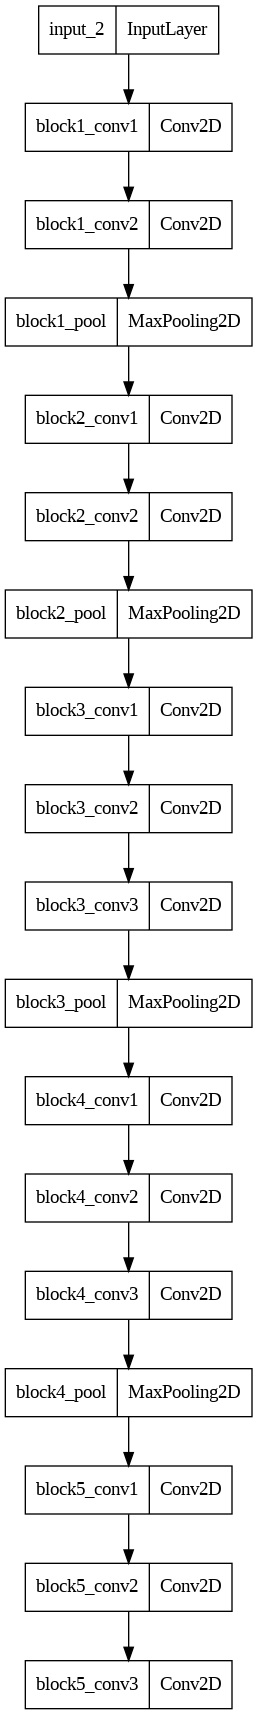

In [ ]:
tf.keras.utils.plot_model(feature_map_model, expand_nested=True)

In [ ]:
test_image = cv2.imread("/content/EmotionsDataset_Splitted/data/test/happy/1012.jpg")
test_image = cv2.resize(test_image, (256, 256))

im = tf.constant(test_image, dtype=tf.float32)
im = tf.expand_dims(im, axis=0)

f_maps = feature_map_model.predict(im)

1/1 [==============================] - 1s 587ms/step


In [ ]:
for i in range(len(f_maps)):
  print(f_maps[i].shape)

(1, 256, 256, 64)
(1, 256, 256, 64)
(1, 128, 128, 128)
(1, 128, 128, 128)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)


In [ ]:
print(len(f_maps))

13


In [ ]:
for i in range(len(f_maps)):
  plt.figure(figsize=(256, 256))
  f_size = f_maps[i].shape[1]
  n_channels = f_maps[i].shape[3]
  joint_maps = np.ones((f_size, f_size*n_channels))

  axes = plt.subplot(len(f_maps), 1, i+1)
  for j in range(n_channels):
    joint_maps[:, f_size*j: f_size*(j+1)] = f_maps[i][..., j]

  plt.imshow(joint_maps[:, 0:512])
  plt.axis('off')

# Vision Transformer

## Patch Encoder

In [ ]:
test_image = cv2.imread("/content/EmotionsDataset/data/happy/108.jpg")
test_image = cv2.resize(test_image, (256,256))

In [ ]:
patches = tf.image.extract_patches(images= tf.expand_dims(test_image, axis=0),
                                   sizes = [1, 16, 16, 1],
                                   strides = [1, 16, 16, 1],
                                   rates=[1, 1, 1, 1],
                                   padding="VALID")

In [ ]:
print(patches.shape)

(1, 16, 16, 768)


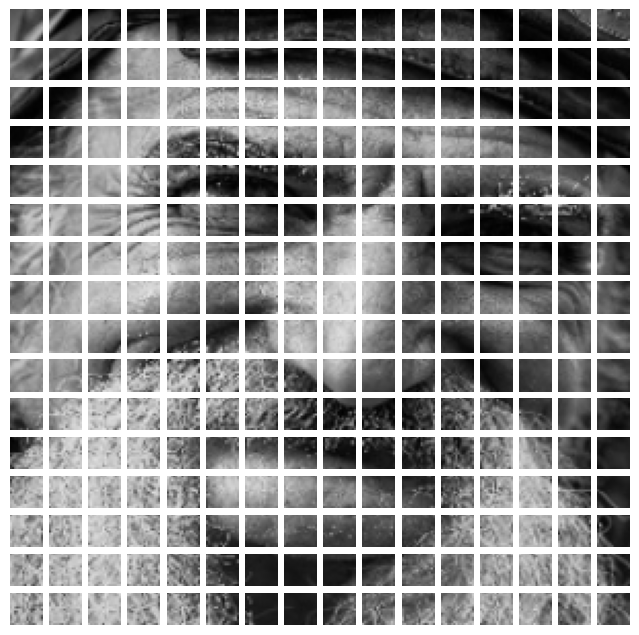

In [ ]:
plt.figure(figsize=(8,8))
k = 0
for i in range(16):
  for j in range(16):

    ax = plt.subplot(16, 16, k+1)
    plt.imshow(tf.reshape(patches[0, i, j, :], (16, 16, 3)))
    plt.axis('off')
    k+=1

In [ ]:
def PatchEncoder(tf.keras.layers.Layer):
  def __init__(self, n_patches, hidden_size):
    super(PatchEncoder,self).__init__(name='patch_encoder')

    self.linear_projection = tf.keras.layers.Dense(hidden_size)
    self.positional_embedding = tf.keras.layers.Embedding()

  def call(self, x):
    patches = tf.keras.layers.extract_patches(
        images = x,
        sizes = [1, 256, 256, 1],
        strides = [1, 256, 256, 1],
        rates = [1, 1, 1, 1],
        padding = 'VALID'
    )
    patches = tf.reshape(patches, (patches.shape[0], -1, patches.shape[-1]))
    output = self.linear_projection(patches)

# Hugging Face VIT

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.7 MB/s eta 0:00:00


In [ ]:
from transformers import ViTModel, ViTConfig

In [ ]:
configuration = ViTConfig()

model = ViTModel(configuration)

configuration = model.config

In [ ]:
print(configuration)

ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.31.0"
}

